In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')


In [ ]:
data = pd.read_csv('/content/household_power_consumption.txt', delimiter=';')
print('Number of rows and columns:', data.shape)
data.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [ ]:
print("\nInformation about the dataframe:")
print(data.info())


Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


In [ ]:
print("\nData type of each column in the dataframe:")
print(data.dtypes)


Data type of each column in the dataframe:
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


In [ ]:
data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data = data.dropna(subset=['Global_active_power'])
data['date_time'] = pd.to_datetime(data['date_time'])
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)

In [ ]:
data = data.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)
print('Number of rows and columns:', data.shape)
print('Minimum date_time:', data.date_time.min())
print('Maximum date_time:', data.date_time.max())
data.tail(5)

Number of rows and columns: (2049280, 7)
Minimum date_time: 2006-12-16 17:24:00
Maximum date_time: 2010-11-26 21:02:00


,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-11-26 20:58:00,0.9460,2010,4,11,26,1
2049276,2010-11-26 20:59:00,0.9440,2010,4,11,26,1
2049277,2010-11-26 21:00:00,0.9380,2010,4,11,26,1
2049278,2010-11-26 21:01:00,0.9340,2010,4,11,26,1
2049279,2010-11-26 21:02:00,0.9320,2010,4,11,26,1


In [ ]:
!pip install stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24283 sha256=597ffcd13d01332acdf4318371320fd3e153087880219199402b54dd390de670
  Stored in directory: /root/.cache/pip/wheels/c9/85/bc/3371b9bce1e4f7b8b638e8c968a4dbd74db171ee180c48f808
Successfully built stats


In [ ]:
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf

%matplotlib inline

import math
import scipy.stats as stat

stat, p = stats.normaltest(data.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320818


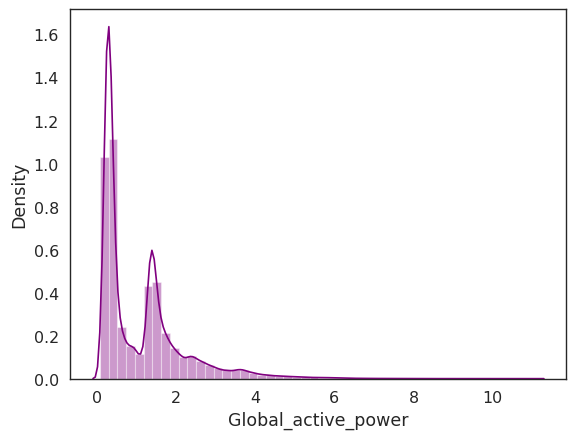

In [ ]:
sns.distplot(data.Global_active_power,color='purple')
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(data.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(data.Global_active_power)))

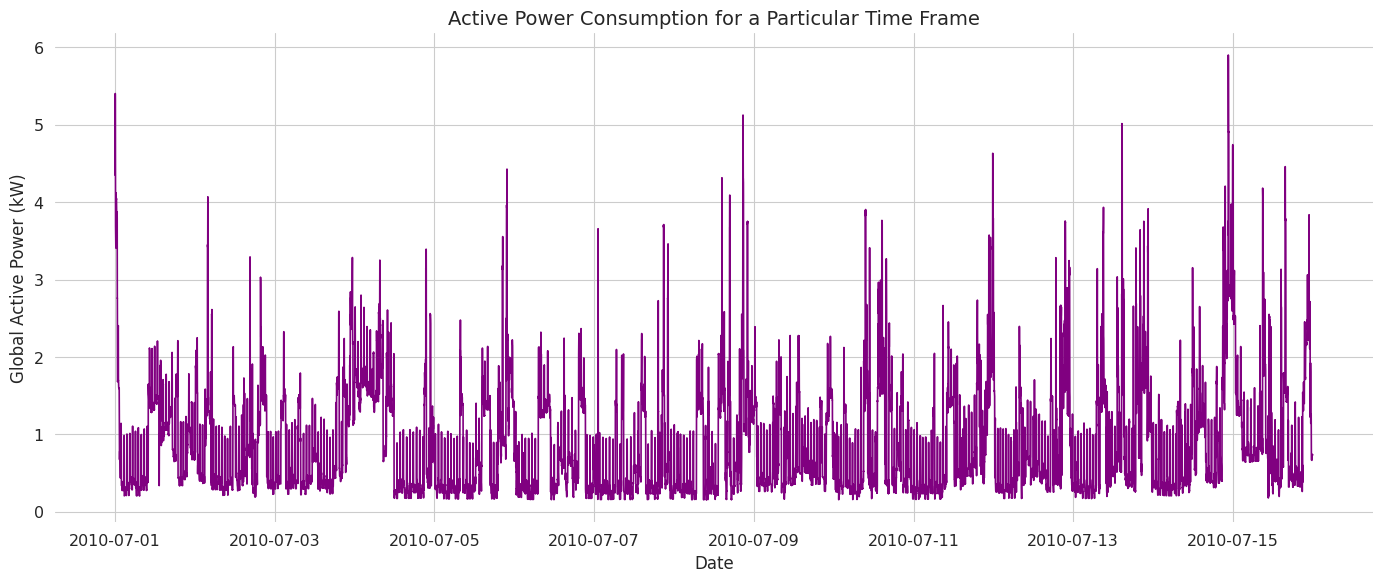

In [ ]:
data1 = data[(data.date_time >= '2010-07-01') & (data.date_time < '2010-7-16')]

plt.figure(figsize=(14,6))
plt.plot(data1.date_time, data1.Global_active_power, color='purple')
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Active Power Consumption for a Particular Time Frame', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

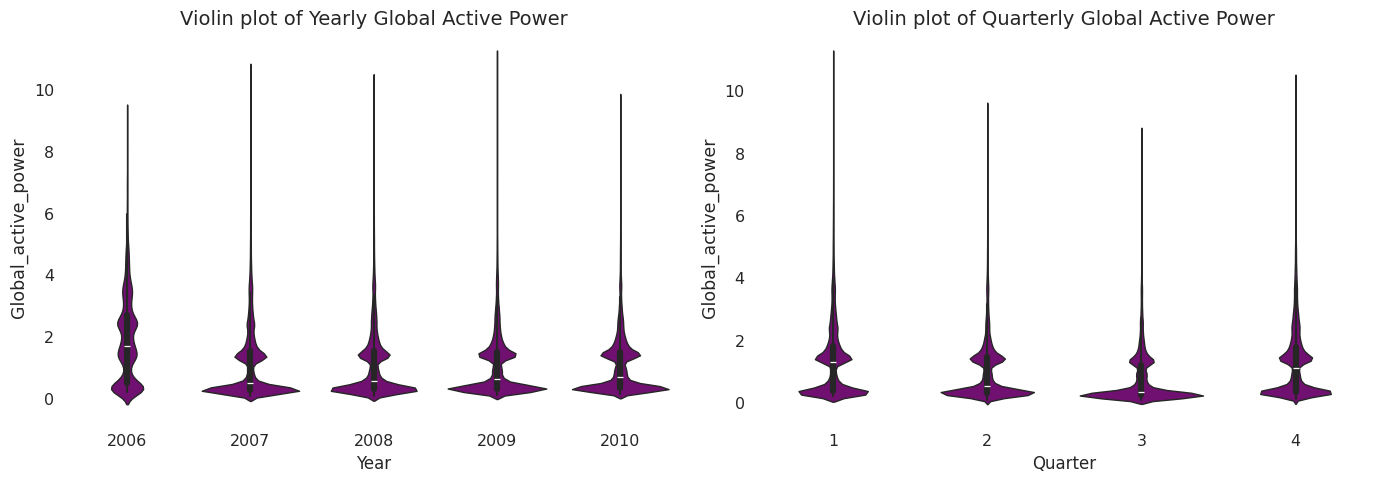

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.violinplot(x="year", y="Global_active_power", data=data, color='purple')
plt.xlabel('Year', fontsize=12)
plt.title('Violin plot of Yearly Global Active Power', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
#for quaterly
plt.subplot(1,2,2)
sns.violinplot(x="quarter", y="Global_active_power", data=data, color='purple')
plt.xlabel('Quarter', fontsize=12)
plt.title('Violin plot of Quarterly Global Active Power', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()

                         count                           mean  \
date_time                21599  2010-07-08 11:59:01.572294912   
Global_active_power 21599.0000                         0.8464   
year                21599.0000                      2010.0000   
quarter             21599.0000                         3.0000   
month               21599.0000                         7.0000   
day                 21599.0000                         7.9997   
weekday             21599.0000                         0.7333   

                                     min                  25%  \
date_time            2010-07-01 00:00:00  2010-07-04 17:59:30   
Global_active_power               0.1580               0.3360   
year                           2010.0000            2010.0000   
quarter                           3.0000               3.0000   
month                             7.0000               7.0000   
day                               1.0000               4.0000   
weekday                 

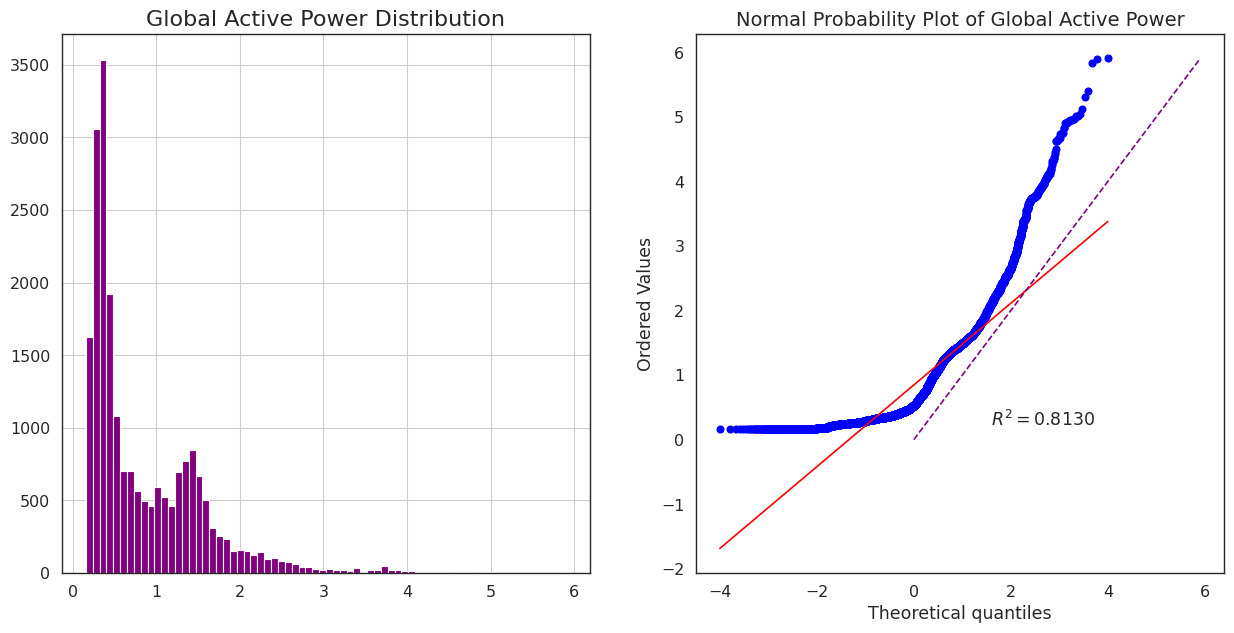

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
data1['Global_active_power'].hist(bins=70, color='purple')
plt.title('Global Active Power Distribution', fontsize=16)
plt.subplot(1,2,2)
stats.probplot(data1['Global_active_power'], plot=plt, fit=True, rvalue=True)
plt.plot([0, max(data1['Global_active_power'])], [0, max(data1['Global_active_power'])], color='purple', linestyle='--')
plt.title('Normal Probability Plot of Global Active Power', fontsize=14)

print(data1.describe().T)

Number of data points in data1: 21599
Type of data1: <class 'pandas.core.frame.DataFrame'>


Text(0.5, 1.0, 'Global Active Power Distribution')

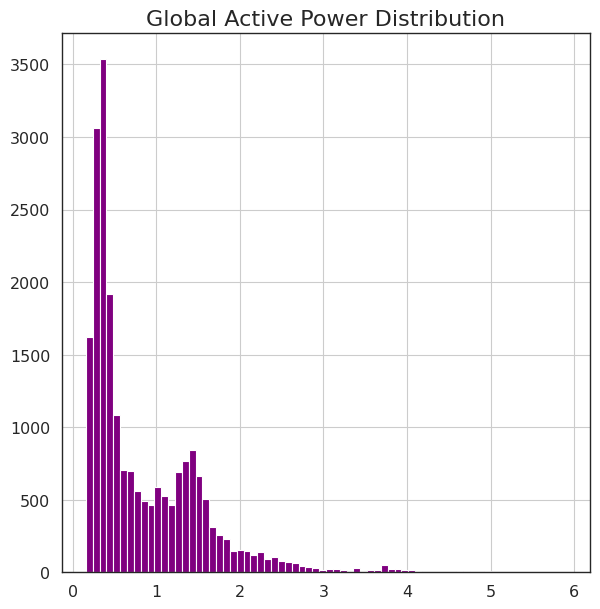

In [ ]:
if data1.empty:
    print("DataFrame 'data1' is empty.")
print("Number of data points in data1:", len(data1))
print("Type of data1:", type(data1))
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
data1['Global_active_power'].hist(bins=70, color='purple')
plt.title('Global Active Power Distribution', fontsize=16)



In [ ]:
data1=data.loc[:,['date_time','Global_active_power']]
data1.set_index('date_time',inplace=True)

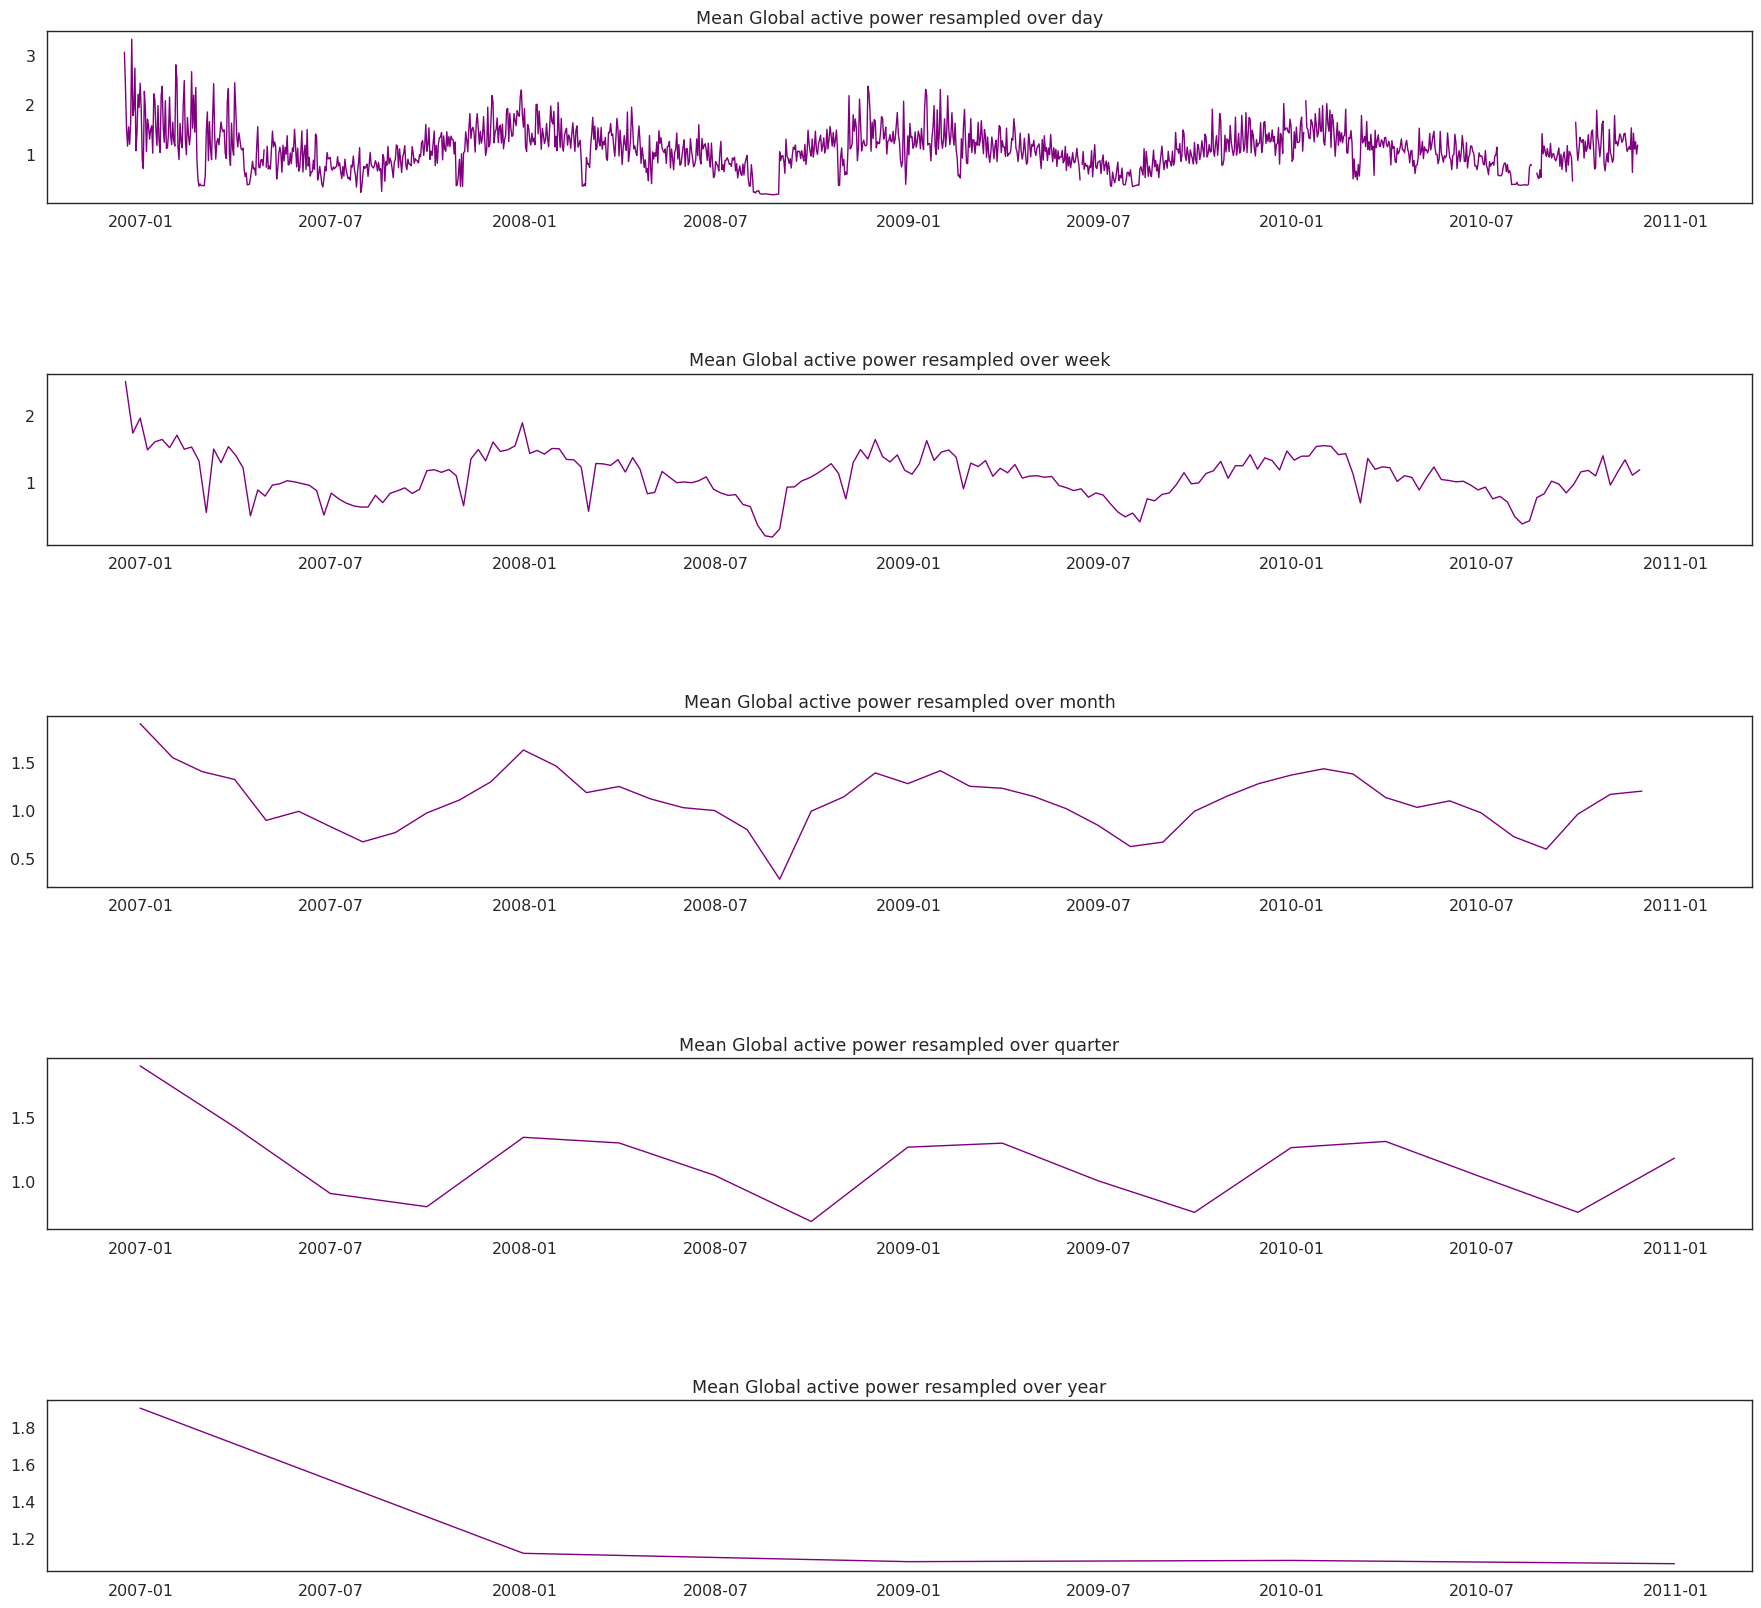

In [ ]:
fig = plt.figure(figsize=(22,20))
fig.subplots_adjust(hspace=1)

#first subplot
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data1['Global_active_power'].resample('D').mean(), linewidth=1, color='purple')
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

#second subplot
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data1['Global_active_power'].resample('W').mean(), linewidth=1, color='purple')
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

#third subplot
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data1['Global_active_power'].resample('M').mean(), linewidth=1, color='purple')
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

#fourth subplot
ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data1['Global_active_power'].resample('Q').mean(),linewidth=1, color='purple')
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

#fifth subplot
ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data1['Global_active_power'].resample('A').mean(),linewidth=1, color='purple')
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major')


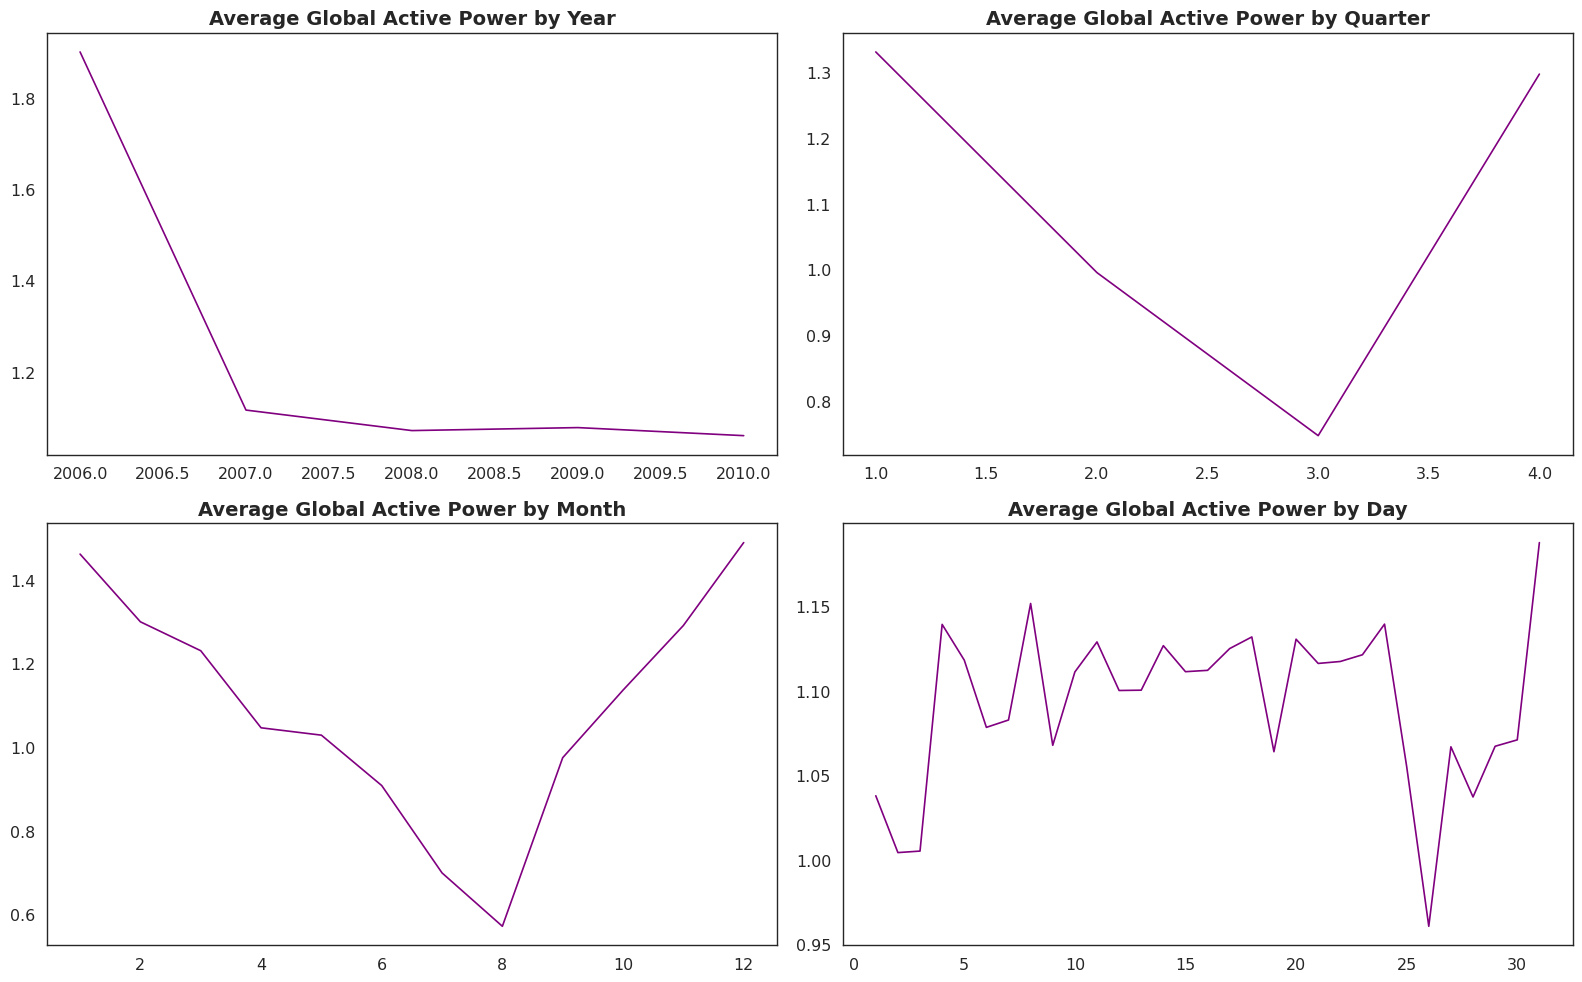

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)

grouped_by_year = data.groupby('year').Global_active_power.agg('mean')
grouped_by_year.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power by Year', fontsize=14, fontweight='bold')

plt.subplot(2,2,2)
grouped_by_quarter = data.groupby('quarter').Global_active_power.agg('mean')
grouped_by_quarter.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power by Quarter', fontsize=14, fontweight='bold')


plt.subplot(2,2,3)
grouped_by_month = data.groupby('month').Global_active_power.agg('mean')
grouped_by_month.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power by Month', fontsize=14, fontweight='bold')


plt.subplot(2,2,4)
grouped_by_day = data.groupby('day').Global_active_power.agg('mean')
grouped_by_day.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power by Day', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
dataset = data.Global_active_power.values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
X_train.shape

(1639393, 30)

In [ ]:
Y_train.shape

(1639393,)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(1639393, 1, 30)

In [ ]:
model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
1323/1323 [==============================] - 36s 25ms/step - loss: 0.0010 - val_loss: 4.0818e-04
Epoch 2/20
1323/1323 [==============================] - 34s 26ms/step - loss: 6.6328e-04 - val_loss: 3.9632e-04
Epoch 3/20
1323/1323 [==============================] - 32s 24ms/step - loss: 6.4474e-04 - val_loss: 3.9152e-04
Epoch 4/20
1323/1323 [==============================] - 31s 24ms/step - loss: 6.3633e-04 - val_loss: 3.9023e-04
Epoch 5/20
1323/1323 [==============================] - 32s 24ms/step - loss: 6.3152e-04 - val_loss: 3.8890e-04
Epoch 6/20
1323/1323 [==============================] - 31s 24ms/step - loss: 6.2913e-04 - val_loss: 3.9139e-04
Epoch 7/20
1323/1323 [==============================] - 31s 24ms/step - loss: 6.2552e-04 - val_loss: 3.8935e-04
Epoch 8/20
1323/1323 [==============================] - 31s 24ms/step - loss: 6.2605e-04 - val_loss: 3.8927e-04
Epoch 9/20
1323/1323 [==============================] - 34s 25ms/step - loss: 6.2301e-04 - val_loss: 3.9025e

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

12808/12808 [==============================] - 34s 3ms/step
Train Mean Absolute Error: 0.09682999167073943
Train Root Mean Squared Error: 0.2691093336201975
Test Mean Absolute Error: 0.08010823379068163
Test Root Mean Squared Error: 0.21821079803219434


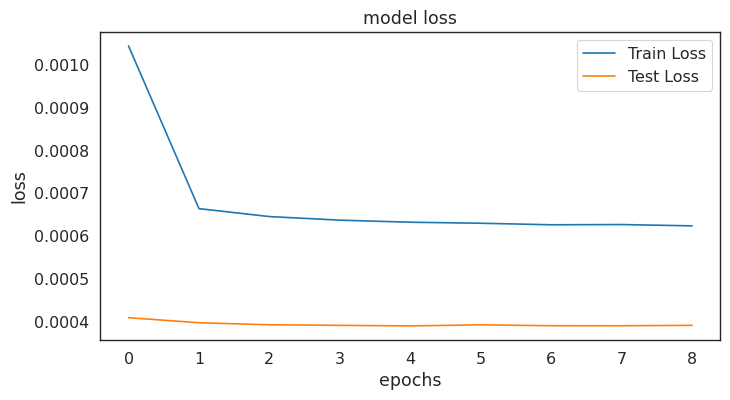

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


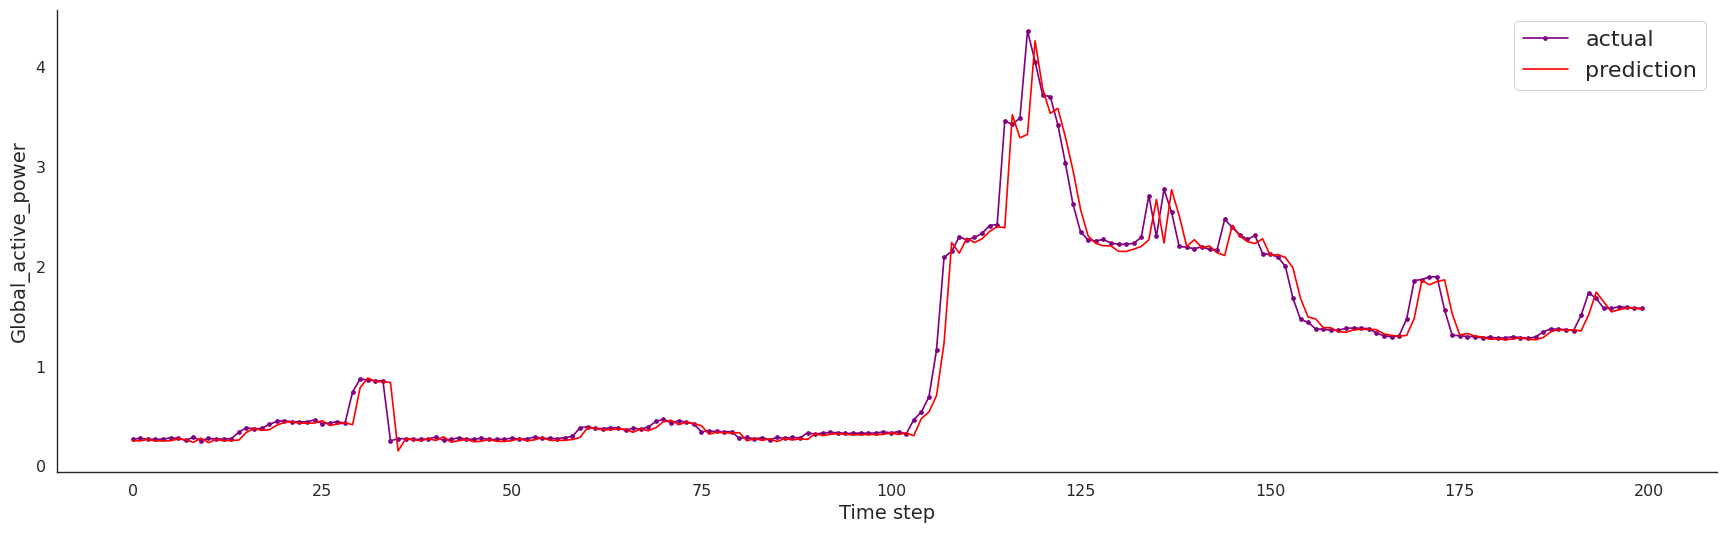

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(20,6))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual", color='purple')
plt.plot(aa, test_predict[:,0][:200], '-', label="prediction", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=14)
plt.xlabel('Time step', size=14)
plt.legend(fontsize=16)
plt.show()


In [ ]:
from sklearn.metrics import r2_score, accuracy_score

Y_train_reshaped = Y_train.T
R2_score = r2_score(Y_train_reshaped, train_predict)
Y_train_reshaped = np.ravel(Y_train)
R2_score = r2_score(Y_train_reshaped, train_predict)
print(R2_score)

0.9393805586409189


In [ ]:
from sklearn.metrics import mean_squared_error
Y_test_reshaped = Y_test.T
MSE = mean_squared_error(Y_test_reshaped, test_predict)
print("Mean squared error on test data:", MSE)


Mean squared error on test data: 0.04761595237784711
Mean absolute error on test data: 0.08010823379068163
